# MAP on Steinmetz
We run our algorithm on the Steinmetz dataset, with an anatomically inspired connectivity matrix.

## Load libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np

from tqdm.auto import trange

from scipy.spatial import distance
from scipy.stats import pearsonr
from scipy.optimize import linear_sum_assignment

import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.distributions.laplace import Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.distributions.dirichlet import Dirichlet
from torch.distributions.gamma import Gamma
from torch.distributions.exponential import Exponential
from torch.distributions.bernoulli import Bernoulli

def seed_everything(seed: int):
    """Sets the seed for generating random numbers in PyTorch, numpy and
    Python.

    Args:
        seed (int): The desired seed.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
def nx_to_laplacian(g, alpha=0.5):
  """
  alpha: float, controls how much we augment the diagonal of the graph Laplacian
  """
  adj_matrix = nx.convert_matrix.to_numpy_array(g)
  deg = np.sum(adj_matrix, axis=1)
  lap = np.diag(alpha + deg) - adj_matrix
  return torch.from_numpy(lap).float()

In [4]:
def initialize_model(K, N, T, g, sigma=0.01, random_seed=0, mask=True, alpha=0.5):
  """
  This function initializes our starting point for MAP estimation on L, D, A

  K : number of factors
  N: number of neurons
  T: number of time steps
  g: the base graph (with N neurons)
  """
  seed_everything(random_seed)
  S = Laplace(0, 1/np.sqrt(2 * T)).sample(sample_shape=(T,K)) # T x k
  D = torch.sqrt(Dirichlet(torch.ones(K) / K).sample(sample_shape=(N,)).T)
  A = torch.abs(MultivariateNormal(torch.zeros(N),  precision_matrix=nx_to_laplacian(g, alpha=alpha)).sample(sample_shape=(K, ))) #k x N

  # let's make the Lambdas
  B = Bernoulli(0.8).sample(sample_shape=(K,))
  L = B * Gamma(10,10).sample(sample_shape=(K,))
  E = (1 - B) * Exponential(1).sample(sample_shape=(K,))
  L = L + E
  L = L.sort().values

  if mask:
    Atilde = torch.diag(L) @ (D * A)
  else:
    Atilde = torch.diag(L) @ A

  Y = Normal(S @ Atilde, sigma).sample() # T x N

  return (S,A,D,L)

In [5]:
def stable_softmax(x):
    """
    Computes the numerically stable softmax of a tensor x on the first dimension.
    """
    max_val, _ = torch.max(x, dim=0, keepdim=True)
    x_exp = torch.exp(x - max_val)
    x_sum = torch.sum(x_exp, dim=0, keepdim=True)
    return x_exp / x_sum
def stable_dirichlet(logit_D):
    return logit_D.sum()

In [6]:
# compute losses
# the problem is the log density of the Dirichlet

def get_loss(Y, S, log_A, logit_D, log_L, g, sigma=0.01, alpha=0.5, beta=0, mask=True):
  T, N = Y.shape
  K, _ = log_A.shape
  A = torch.exp(log_A)
  L = torch.exp(log_L)
  if mask:
    D = torch.sqrt(stable_softmax(logit_D.T).T)  # D_i^2 is Dirichlet

  loss = 0
  # priors
  loss += -Laplace(0, 1/np.sqrt(2 * T)).log_prob(S).sum()
  loss += -MultivariateNormal(torch.zeros(N), precision_matrix=nx_to_laplacian(g, alpha=alpha)).log_prob(A).sum()
  if mask:
    loss += stable_dirichlet(logit_D)
  
  # Lambda loss
  gam = torch.log(torch.tensor(0.8)) + Gamma(10,10).log_prob(L)
  exp = torch.log(torch.tensor(0.2)) + Exponential(1).log_prob(L)
  cat = torch.vstack([gam, exp])
  loss += -torch.logsumexp(cat, 0).sum()


  # likelihood
  if mask:
    Atilde = A * D
    if D.isnan().sum() > 0:
      print("D is nan")
      print(D)
  else:
    Atilde = A
  loss += -Normal(S @ torch.diag(L) @ Atilde, sigma).log_prob(Y).sum()
  # l1 regularization
  loss += beta * torch.linalg.norm(A)
  return loss / T

In [7]:
def map_estimation(Y,
                   g,
                   K, 
                   N,
                   num_steps=10000,
                   alpha=0.5,
                   beta=0,
                   mask=False,
                   random_seed=1,
                   tol_steps=1000):
  pbar = trange(num_steps)
  pbar.set_description("---")
  T, N = Y.shape
  # intialization
  S, A, D, L = initialize_model(K, N, T, g, random_seed=random_seed, mask=mask, alpha=alpha)
  S = nn.parameter.Parameter(S)
  log_A = nn.parameter.Parameter(torch.log(A))
  logit_D = nn.parameter.Parameter(2 * torch.log(D)) #D_i^2 ~ Dirichlet
  log_L = nn.parameter.Parameter(torch.log(L))

  S_best = S
  log_A_best = log_A
  logit_D_best = logit_D
  log_L_best = log_L
  s = 0

  best_loss = float('inf')
  optimizer = optim.Adam([S,log_A, logit_D, log_L], lr=1e-1)
  train_losses = []
  for step in pbar:
    if step-s > max(tol_steps,s):
      break
    with torch.set_grad_enabled(True):
        optimizer.zero_grad()
        loss = get_loss(Y, S, log_A, logit_D, log_L, g, beta=beta, mask=mask)
        if loss < best_loss:
          s = step
          log_L_best = log_L.detach().clone()
          sort = log_L_best.sort()
          log_L_best = sort.values
          idxs = sort.indices

          S_best = S.detach().clone()
          S_best = S_best[:, idxs]

          log_A_best = log_A.detach().clone()
          log_A_best = log_A_best[idxs, :]

          logit_D_best = logit_D.detach().clone()
          logit_D_best = logit_D_best[idxs, :]

          best_loss = loss
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())

  print(s)
  return S_best, torch.exp(log_A_best), torch.sqrt(stable_softmax(logit_D_best)), torch.exp(log_L_best), train_losses

In [8]:
def make_stability_mat(A1, L1, D1, A2, L2, D2, ard=False, mask=False):
  K, _ = A1.shape
  if mask and ard:
    A_target = torch.diag(L1) @ (D1 * A1)
  elif ~mask and ard:
    A_target = torch.diag(L1) @ A1
  else:
    A_target = A1
  return make_recovery_mat(A_target, A2, L2, D2, ard=ard, mask=mask)

def make_recovery_mat(A_true, A_est, L_est, D_est, ard=False, mask=False):
  K_true, _ = A_true.shape
  K_used, _ = A_est.shape
  sim = np.zeros((K_true,K_used))
  for i in range(K_true):
    for j in range(K_used):
      if mask and ard:
        sim[i,j] = pearsonr(A_true[i], L_est[j] * D_est[j] * A_est[j])[0]
      elif ~mask and ard:
        sim[i,j] = pearsonr(A_true[i], L_est[j] * A_est[j])[0]
      else:
        sim[i,j] = pearsonr(A_true[i], A_est[j])[0]
  
  # just need to reorder the columns of sim according to the Hungarian algorithm
  if K_true==K_used:
    p = linear_sum_assignment(-sim)[1]
    sim = sim[:, p]

  return sim

## Application Steinmetz

### load in Steinmetz data

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
import torch

In [10]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [11]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [12]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [13]:
# Take a single mouse (the sample notebook takes mouse 11, since it has some neurons from vis_ctx)
# The rest of this notebook will just focus on this mouse
dat = alldat[11]

In [14]:
def get_successful_trials(dat): 
  """
  Drop the trials where the mouse failed to correctly distinguish the contrast 
  identification challenge.

  This returns the spike data on successful trials.

  TODO: might want to wrap this into a whole data cleaning function that returns 
  the cleaned dat dictionary object instead of just spikes.
  """
  result = np.zeros_like(dat["contrast_right"])
  mask1 = dat["contrast_right"] > dat["contrast_left"]
  mask2 = dat["contrast_left"] > dat["contrast_right"]
  result[mask1] = -1
  result[mask2] = 1

  success_idx = np.where(result == dat["response"])
  success_idx = np.squeeze(success_idx)

  return dat["spks"][:, success_idx, :]

In [15]:
success_dat = get_successful_trials(dat)
success_dat.shape

(698, 236, 250)

In [16]:
steinmetz_adj = pd.read_csv("/content/drive/MyDrive/connectome_prior/steinmetz.csv", dtype=int)

G = nx.Graph(steinmetz_adj.values)

In [17]:
Y = success_dat[:, 0, :]
Y.shape

(698, 250)

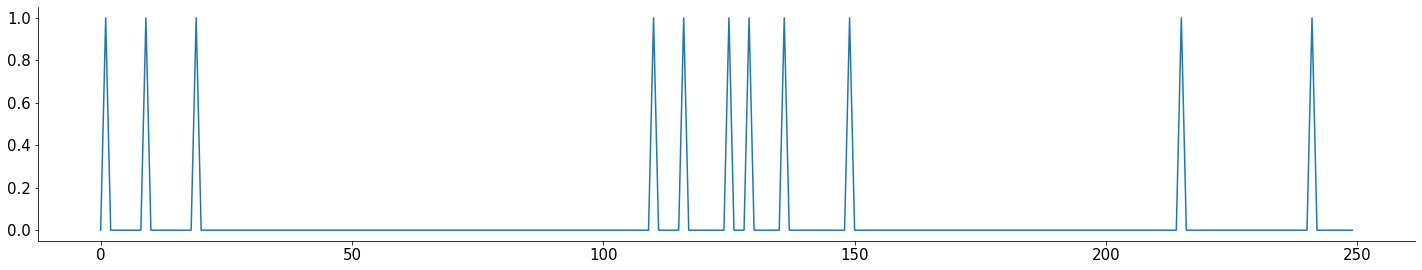

In [18]:
plt.plot(Y[0, :])

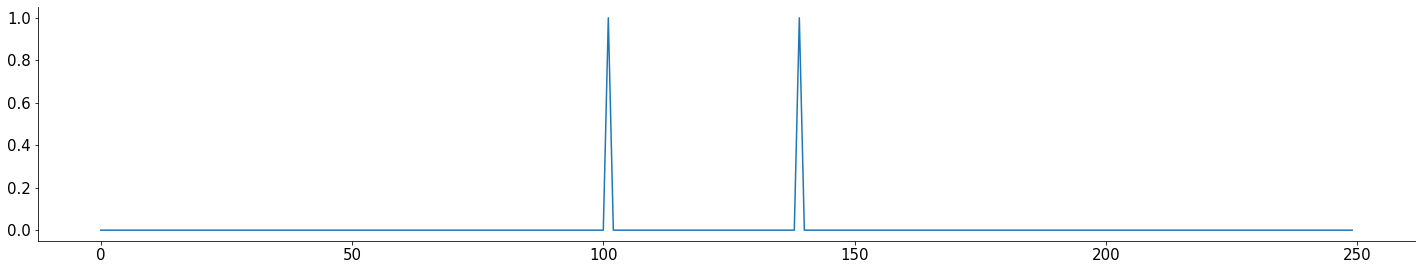

In [19]:
plt.plot(Y[1, :])

In [20]:
MASK = False
ARD = True
N = 698
ALPHA = 0.5

In [21]:
K = 10
S1_map, A1_map, D1_map, L1_map, train1_losses = map_estimation(torch.tensor(Y.T), G, K, N, mask=MASK, random_seed=1)
S2_map, A2_map, D2_map, L2_map, train2_losses = map_estimation(torch.tensor(Y.T), G, K, N, mask=MASK, random_seed=2)

  0%|          | 0/10000 [00:00<?, ?it/s]

8953


  0%|          | 0/10000 [00:00<?, ?it/s]

9829


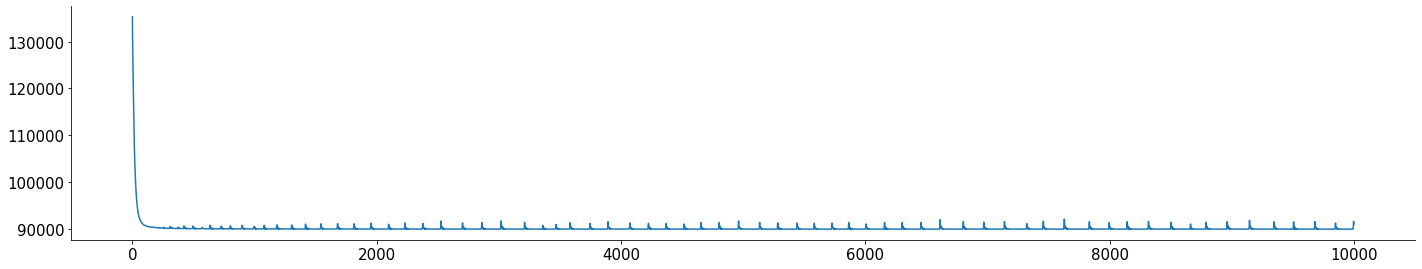

In [22]:
plt.plot(train1_losses)

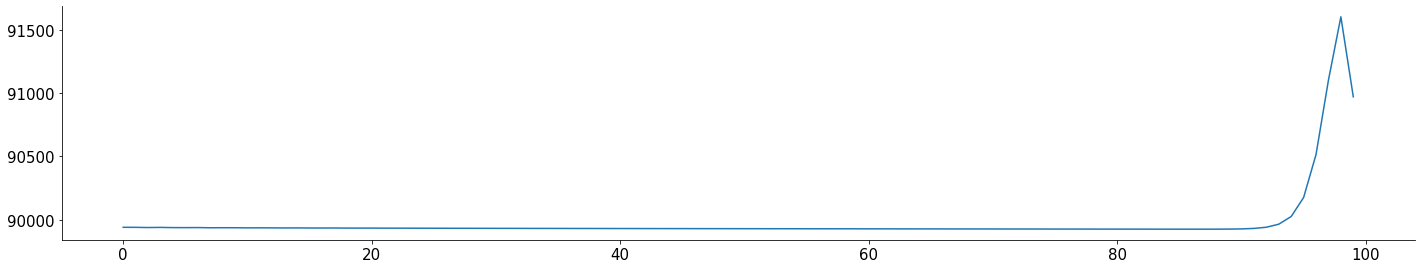

In [23]:
plt.plot(train1_losses[-100:])

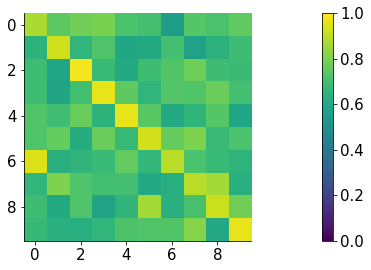

In [24]:
sim = make_stability_mat(A1_map, L1_map, D1_map, A2_map, L2_map, D2_map, ard=ARD, mask=MASK)
plt.imshow(sim, vmin=0, vmax=1)
plt.colorbar()

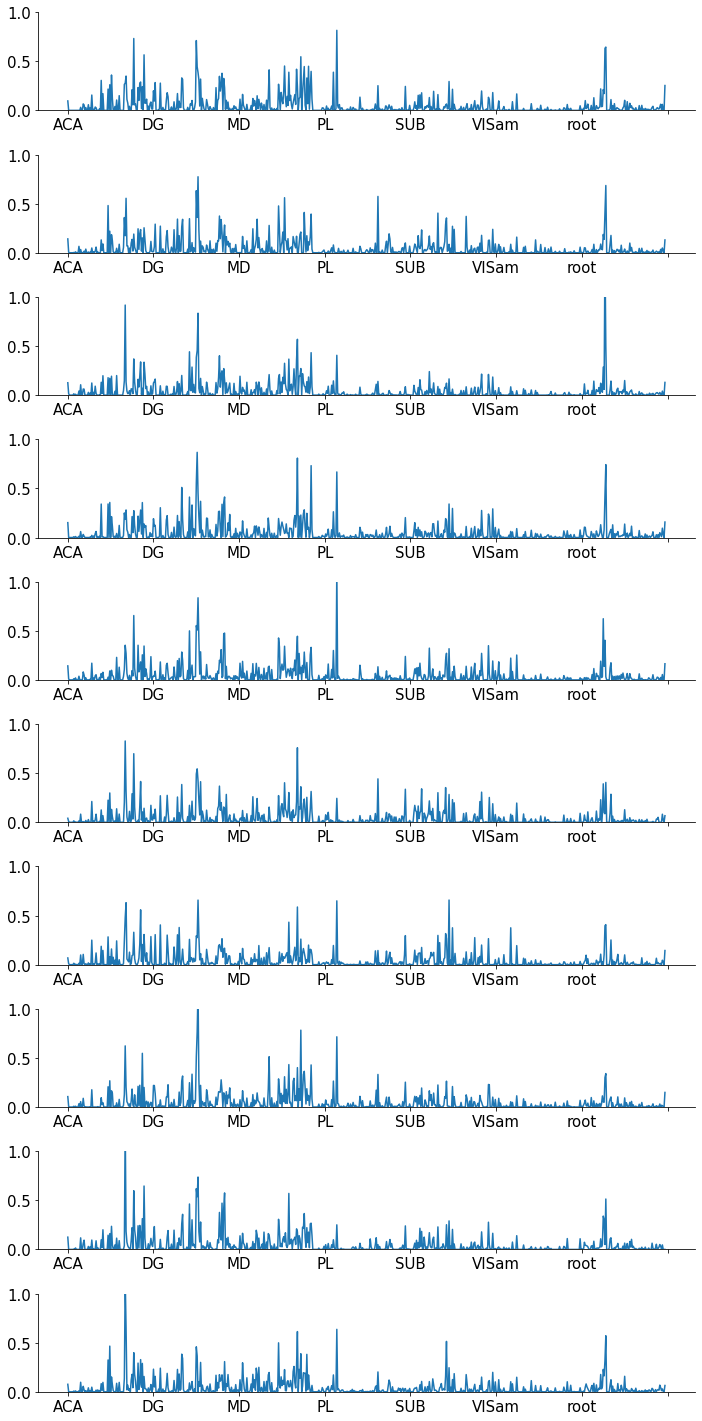

In [26]:
df_A = pd.DataFrame(torch.diag(L1_map) @ A1_map.numpy())
df_A.columns = dat['brain_area']
sort_idx = np.argsort(dat['brain_area'])
df_A = df_A.iloc[:, sort_idx]
fig, axes = plt.subplots(nrows=K, ncols=1, figsize=(10, 20))
for i in range(10):
  row = df_A.iloc[i, :]
  row.plot(ax=axes[i])
  axes[i].set_ylim([0,1])
plt.show()